# 1. Подготовка и предварительная обработка данных

In [76]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Определение преобразований для увеличения и нормализации данных
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Загрузка наборов данных с применением преобразований
train_dataset = ImageFolder('data/train', transform=train_transforms)
val_dataset = ImageFolder('data/validate', transform=val_transforms)

# Создание DataLoader'ов
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 2. Архитектура CNN и трансферное обучение

### 2.1. Разработка 3 различных архитектур

In [77]:
import torch.nn as nn
import torch.nn.functional as F

# Архитектура 1
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, len(train_dataset.classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Архитектура 2
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, len(train_dataset.classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Архитектура 3
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, len(train_dataset.classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 2.2. Трансферное обучение

In [78]:
from torchvision import models

def create_model_transfer(model_name, num_classes):
    if model_name == "resnet":
        model = models.resnet18(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    return model

model_1_transfer = create_model_transfer("resnet", len(train_dataset.classes))
model_2_transfer = create_model_transfer("resnet", len(train_dataset.classes))
model_3_transfer = create_model_transfer("resnet", len(train_dataset.classes))

# 3. Обучение CNN

### 3.1. Обучение с функциями потерь, оптимизаторами и регуляризацией

In [79]:
import torch
import torch.optim as optim

def train_model(model, train_loader, val_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Initialize lists to track loss and accuracy
    train_losses, val_losses, val_accuracies = [], [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Record the average training loss
        train_losses.append(running_loss / len(train_loader))
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Record the average validation loss and accuracy
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)
        
        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')
    
    # Return the model and the recorded metrics
    return model, train_losses, val_losses, val_accuracies

### 3.2. Предотвращение переобучения и недообучения

Переобучение и недообучение можно предотвратить, регулярно проверяя производительность модели на валидационном наборе данных и применяя методы, такие как Dropout и ранняя остановка.

# 4. Настройка гиперпараметров

### 4.1. Как настраивать гиперпараметры

Настройка гиперпараметров может быть выполнена через ручную настройку, сеточный поиск (Grid Search) или случайный поиск (Random Search).

### 4.2. Сравнение результатов обучения

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch

def plot_results(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'go-', label='Validation accuracy')
    plt.title('Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Epoch 1:
Train Loss: 1.1913, Val Loss: 0.8553, Val Acc: 58.97%
Epoch 2:
Train Loss: 0.9795, Val Loss: 0.7422, Val Acc: 64.10%
Epoch 3:
Train Loss: 0.8888, Val Loss: 0.6369, Val Acc: 61.54%
Epoch 4:
Train Loss: 0.8149, Val Loss: 0.6486, Val Acc: 74.36%
Epoch 5:
Train Loss: 0.7615, Val Loss: 0.5207, Val Acc: 69.23%
Epoch 6:
Train Loss: 0.7477, Val Loss: 0.5082, Val Acc: 76.92%
Epoch 7:
Train Loss: 0.6948, Val Loss: 0.4583, Val Acc: 74.36%
Epoch 8:
Train Loss: 0.6815, Val Loss: 0.4299, Val Acc: 74.36%
Epoch 9:
Train Loss: 0.6557, Val Loss: 0.4058, Val Acc: 79.49%
Epoch 10:
Train Loss: 0.6486, Val Loss: 0.4106, Val Acc: 74.36%


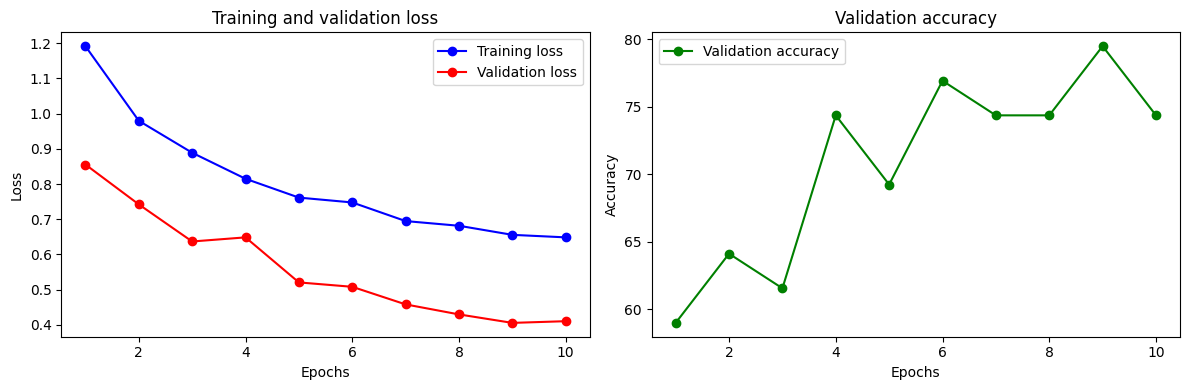

Epoch 1:
Train Loss: 1.0307, Val Loss: 0.8840, Val Acc: 64.10%
Epoch 2:
Train Loss: 0.9440, Val Loss: 0.5710, Val Acc: 71.79%
Epoch 3:
Train Loss: 0.8585, Val Loss: 0.5453, Val Acc: 69.23%
Epoch 4:
Train Loss: 0.7840, Val Loss: 0.5119, Val Acc: 76.92%
Epoch 5:
Train Loss: 0.7762, Val Loss: 0.4522, Val Acc: 64.10%
Epoch 6:
Train Loss: 0.7027, Val Loss: 0.4499, Val Acc: 79.49%
Epoch 7:
Train Loss: 0.6703, Val Loss: 0.4003, Val Acc: 74.36%
Epoch 8:
Train Loss: 0.6643, Val Loss: 0.3916, Val Acc: 79.49%
Epoch 9:
Train Loss: 0.6221, Val Loss: 0.3630, Val Acc: 79.49%
Epoch 10:
Train Loss: 0.6179, Val Loss: 0.3635, Val Acc: 79.49%


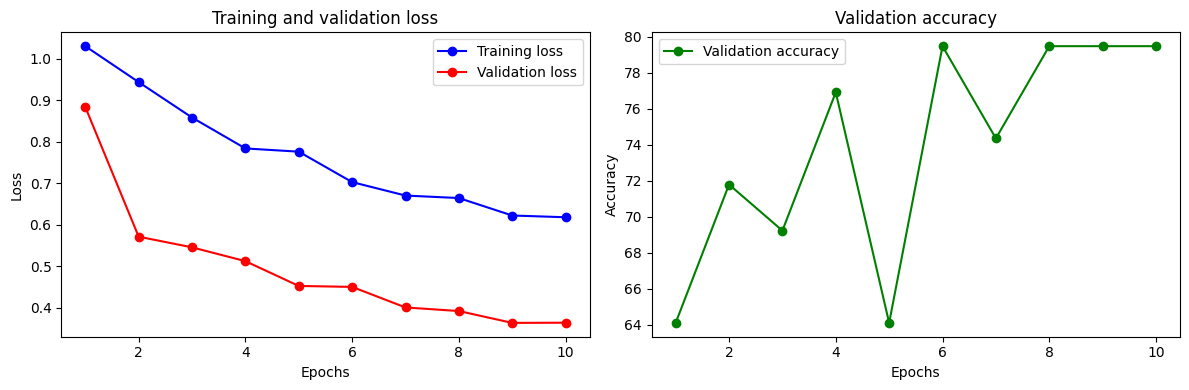

Epoch 1:
Train Loss: 0.6189, Val Loss: 0.3483, Val Acc: 74.36%
Epoch 2:
Train Loss: 0.5647, Val Loss: 0.3451, Val Acc: 84.62%
Epoch 3:
Train Loss: 0.5841, Val Loss: 0.3189, Val Acc: 82.05%
Epoch 4:
Train Loss: 0.5972, Val Loss: 0.3144, Val Acc: 82.05%
Epoch 5:
Train Loss: 0.5652, Val Loss: 0.3251, Val Acc: 82.05%
Epoch 6:
Train Loss: 0.6049, Val Loss: 0.2959, Val Acc: 82.05%
Epoch 7:
Train Loss: 0.5551, Val Loss: 0.3144, Val Acc: 84.62%
Epoch 8:
Train Loss: 0.5732, Val Loss: 0.3624, Val Acc: 82.05%
Epoch 9:
Train Loss: 0.5209, Val Loss: 0.2934, Val Acc: 84.62%
Epoch 10:
Train Loss: 0.5276, Val Loss: 0.2855, Val Acc: 79.49%


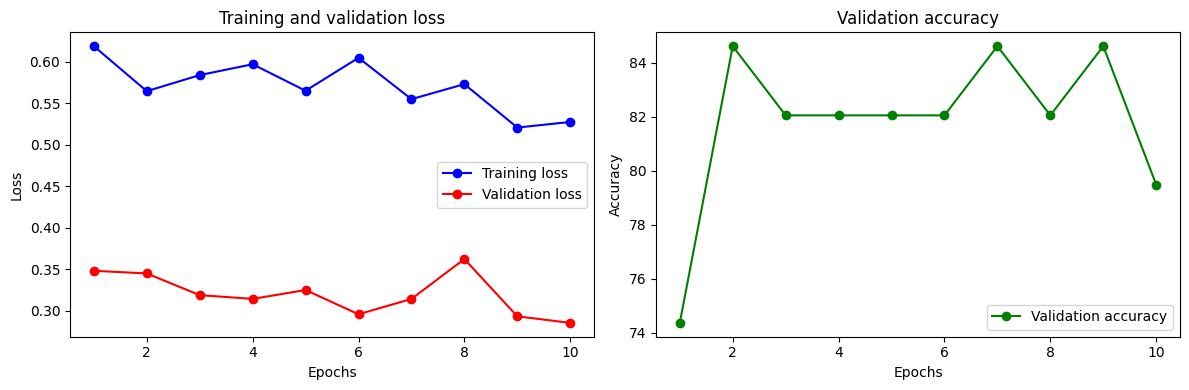

In [81]:
# Define device: use GPU if available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model_1_transfer.to(device)
model_1_transfer, train_losses, val_losses, val_accuracies = train_model(model_1_transfer, train_loader, val_loader, num_epochs=10)
# Plot the results
plot_results(train_losses, val_losses, val_accuracies)


# Move the model to the device
model_2_transfer.to(device)
model_2_transfer, train_losses, val_losses, val_accuracies = train_model(model_2_transfer, train_loader, val_loader, num_epochs=10)
# Plot the results
plot_results(train_losses, val_losses, val_accuracies)


# Move the model to the device
model_2_transfer.to(device)
model_2_transfer, train_losses, val_losses, val_accuracies = train_model(model_2_transfer, train_loader, val_loader, num_epochs=10)
# Plot the results
plot_results(train_losses, val_losses, val_accuracies)